### Word generator
Network are learned to predict next letter of a word from a list of 20k words.
After that it creates its own word by passing output letter to input.

Here we set up plot inlining options and its size:

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 12)
from IPython import display

Import modules:

In [2]:
import pynn as nn
import pynnui as nnui
import math
from math import floor
from random import random, shuffle
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import signal

Char to index and back conversion:

In [3]:
def idx(c):
    a = ord(c)
    if a >= 0x61 and a <= 0x7A:
        return a - 0x61
    if a == 0x27: # '
        return 0x1A
    if a == 0x2D: # -
        return 0x1B
    if a == 0xA:  # CR
        return 0x1C
    return -1

def char(i):
    if i >= 0 and i <= 0x19:
        return chr(i + 0x61)
    if a == 0x1A: # '
        return chr(0x27)
    if a == 0x1B: # -
        return chr(0x2D)
    if a == 0x1C: # CR
        return chr(0xA)
    return ''

To learn our network we use [BPTT](https://en.wikipedia.org/wiki/Backpropagation_through_time) with [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) plus [AdaGrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad). [Softmax](https://en.wikipedia.org/wiki/Softmax_function) loss is used.

In [4]:
def do_batch(net, pos, batch_size):
    loss = 0
    grad = net.newGradient()
    backprop_count = 0
       
    for i in range(min(batch_size, len(words) - pos)):
        word = words[pos + i]
        depth = len(word)

        state = net.newState()
        state.pipes[net._flink[(1, 0)]].data = np.zeros(shid)
        state_stack = [state]

        vouts_stack = []

        for l in range(depth - 1):
            a = idx(word[l])
            lin = [0]*size
            lin[a] = 1
            vins = [np.array(lin)]

            # feedforward
            state = copy(state)
            vouts = net.transmit(state, vins)
            state_stack.append(state)
            vouts_stack.append(vouts)

        error = net.newError()
        error.pipes[net._blink[(1, 0)]].data = np.zeros(shid)

        for l in range(depth - 1):
            a = idx(word[depth - l - 1])
            lres = [0]*size
            lres[a] = 1
            vres = np.array(lres)
            vin = vouts_stack.pop()[0]
            vout = np.exp(vin)/np.sum(np.exp(vin))
            verrs = [vout - vres]
            loss += -np.log(vout[a])

            # backpropagate
            net.backprop(grad, error, state_stack.pop(), verrs)
            backprop_count += 1
            
    grad.mul(1/backprop_count)
    return (grad, loss/batch_size)

Define network structure:

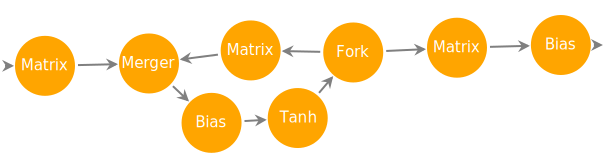

In [5]:
net = nn.Network(1, 1)
size = 0x1D
shid = 0x80

net.nodes[0] = nn.MatrixProduct(size, shid) # W_xh
net.nodes[1] = nn.MatrixProduct(shid, shid) # W_hh
net.nodes[2] = nn.Merger(shid, 2)
net.nodes[3] = nn.Bias(shid)
net.nodes[4] = nn.Tanh(shid)
net.nodes[5] = nn.Fork(shid, 2)
net.nodes[6] = nn.MatrixProduct(shid, size) # W_hy
net.nodes[7] = nn.Bias(size)

net.paths.append(nn.Path((-1, 0), ( 0, 0)))
net.paths.append(nn.Path(( 0, 0), ( 2, 0)))
net.paths.append(nn.Path(( 1, 0), ( 2, 1)))

net.paths.append(nn.Path(( 2, 0), ( 3, 0)))
net.paths.append(nn.Path(( 3, 0), ( 4, 0)))
net.paths.append(nn.Path(( 4, 0), ( 5, 0)))

net.paths.append(nn.Path(( 5, 1), ( 1, 0)))
net.paths.append(nn.Path(( 5, 0), ( 6, 0)))
net.paths.append(nn.Path(( 6, 0), ( 7, 0)))
net.paths.append(nn.Path(( 7, 0), (-1, 0)))

net.update()

rate = nn.RateAdaGrad(net, 1e-1)

b = 0
p = 0
smooth_loss = 0
losses = []
epoch = 0
epochs = []

display.SVG(data=nnui.Graph(net).svg())

Load data:

In [6]:
batch_size = 20

file = open('data/20k.txt')
words = []
for word in file:
    words.append(word)

# del words[2000:]

Main learning loop. You can interrupt it and continue whenever you want.

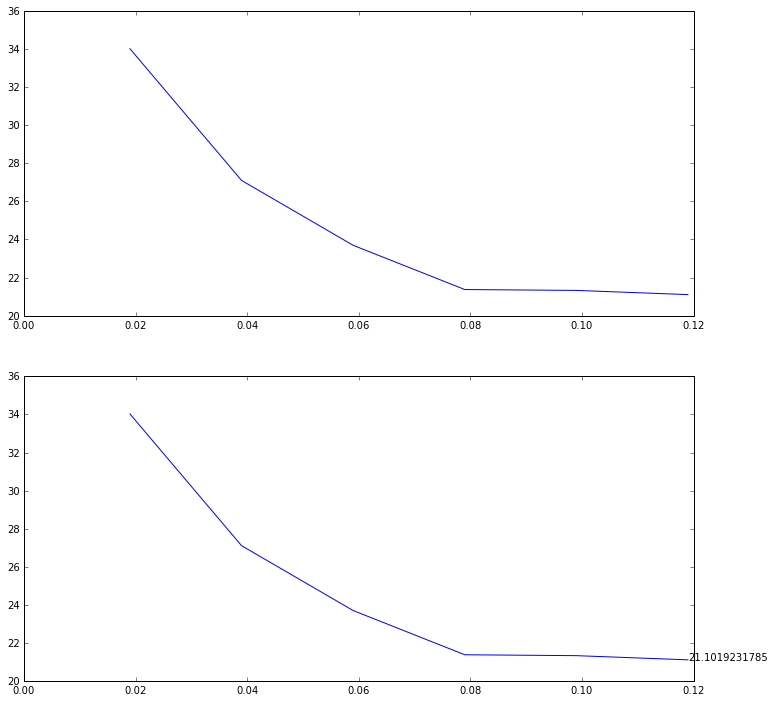

'done'

In [7]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

show_period = 20
while not done:
    if p >= len(words):
        p = 0
        b = 0
        epoch += 1
    if p == 0:
        shuffle(words)
    
    (grad, loss) = do_batch(net, p, batch_size)
    grad.clip(5e0)
    rate.update(grad)
    net.learn(grad, rate)
    
    smooth_loss = 0.9*smooth_loss + 0.1*loss
    
    if (b+1) % show_period == 0:
        smooth_epoch = epoch + p/len(words)
        epochs.append(smooth_epoch)
        losses.append(smooth_loss)

        fig = plt.figure()
        ax = (fig.add_subplot(211), fig.add_subplot(212))
        ax[0].plot(epochs, losses)
        r = max(len(losses) - 100, 0)
        ax[1].plot(epochs[r:],losses[r:])
        ax[1].text(smooth_epoch,smooth_loss,str(smooth_loss))

        display.clear_output(wait=True)

        plt.show()
        
    p += batch_size
    b += 1
    
'done'

Here network generates word for each alphabet letter.

In [28]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

for j in range(len(alphabet)):

    state = net.newState()
    state.pipes[net._flink[(1, 0)]].data = np.zeros(shid)

    a = idx(alphabet[j])
    print(alphabet[j], end='')

    for i in range(0x40):
        lin = [0]*size
        lin[a] = 1
        vins = [np.array(lin)]
        vouts = net.transmit(state, vins)
        prob = np.exp(vouts[0])/np.sum(np.exp(vouts[0]))
        a = np.random.choice(range(size), p=prob)
        letter = char(a)

        if letter == '\n':
            break
        print(letter, end='')
    print()

an
bluecl
ciuribog
detmatoiptkduiam
efiu
farpit
gurintydcsne
halp
imr
jeuxlbcay
kreaanro
ligcglmaseu
mhc
nand
ofia
pordd
querl
rucruso
stopraa
tlrurosera
uneelh
vormti
werg
xehse
ypx
zrer
